In [2]:
# Imports
#using Pkg # Make sure everything is installed
#Pkg.add(["DataFrames", "Plots", "StatsBase", "Distributions", "Statistics", "LsqFit", "Distributed",
# "NaNStatistics", "Revise", "ColorSchemes", "Measures"])
using DataFrames, Plots, StatsBase, Distributions, Statistics, LsqFit, Distributed,
      NaNStatistics, Base.Threads, Revise, ColorSchemes, Measures
include.(("ConstantSimulations.jl", "StaircaseSimulations.jl"))

# Psychophysics helper functions
jnd2sigma(j::Real) = (1 /quantile(Normal(), 0.75)) * j # Convert JND to σ
sigma2k(sigma::Real) = 1.7 / sigma; # Convert σ to k
sigmoid(x::Vector, coeffs::Vector) = 1 ./ (1 .+ exp.(-coeffs[1].*(x.-coeffs[2])))

# Plotting defaults
font = Plots.font("Helvetica", 9, "rgb(200,200,200)")
gr() # GR backend
gr(guidefont=font, xtickfont=font, ytickfont=font, annotationfontfamily=font, annotationfontsize=9,
 legend=false, background_color = "rgb(30,30,30)", linewidth=2);

##### Defining the Psychometric Function
We first define an example psychophysical response function defined as a cumulative normal distribution where we define the detection threshold (μ) and just noticeable difference (which we then convert to σ). You can edit the 'detection_threshold' and 'jnd' values and re-run the cell to see how the shape of the psychometric curve changes. Note that the JND is defined as half of the distance between p(.75) and p(.25) stimulus levels. Thus, on the graph below the JND lines indicate the p(.25) and p(.75) values, but the JND is half range between them.

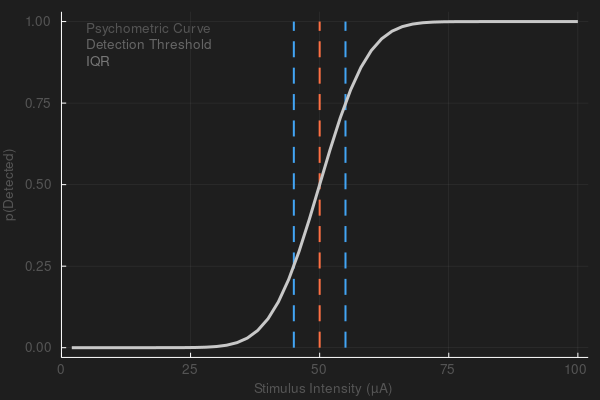

In [3]:
valid_stims = collect(2:2:100) # These are the amplitudes that can be given 
detection_threshold = 50 # microamps
jnd = 5 # microamps
sigma = jnd2sigma(jnd) # Convert for producing normal distribution
psychometric_pdf = Normal(detection_threshold, sigma) # The normal distribution
pDetected = cdf(psychometric_pdf, valid_stims) # Response probability at each stimulus

labels = ["Psychometric Curve", "Detection Threshold", "IQR"]
label_colors = ["rgb(200,200,200)", "rgb(255, 112, 67)", "rgb(66, 165, 245)"]

GroundTruthPlot = plot(xlabel = "Stimulus Intensity (μA)",ylabel = "p(Detected)", xlim=(0, 102))
    plot!(GroundTruthPlot, [detection_threshold, detection_threshold], [0, 1],
     linecolor = "rgb(255, 112, 67)", linestyle = :dash, linewidth = 2)
    plot!(GroundTruthPlot, [detection_threshold, detection_threshold].- jnd, [0, 1],
        color = "rgb(66, 165, 245)", linewidth = 2, linestyle = :dash) # detection_threshold
    plot!(GroundTruthPlot, [detection_threshold, detection_threshold].+ jnd, [0, 1],
        color = "rgb(66, 165, 245)", linewidth = 2, linestyle = :dash) # JND
    plot!(GroundTruthPlot, valid_stims, pDetected, linecolor="rgb(200,200,200)", linewidth = 3)

    yl = 1; y_dec = .05
    for (l,c) in zip(labels, label_colors)
        annotate!(GroundTruthPlot, 5, yl, l, annotationhalign=:left, annotationvalign=:top, annotationcolor=c)
        yl -= y_dec
    end
    display(GroundTruthPlot)

##### Unconstrained Method of Constants:
With no prior knowledge of the psychometric curve we have to span the full range of stimuli and sample the response probability at each stimulus level. Importantly, we will always simulate this as an 2-Alternate Forced Choice (2AFC) experiment as this is the most commonly used format as it minimizes response bias without extending the duration of the experiment excessively. This means that there is a chance (1/#AFC) that the testee will select the correct interval randomly. Thus, the p(Detected) needs to be adjusted to account for this. This reduces probability bias but, as can be seen below, massively increases the variability in the measured p(Detected).

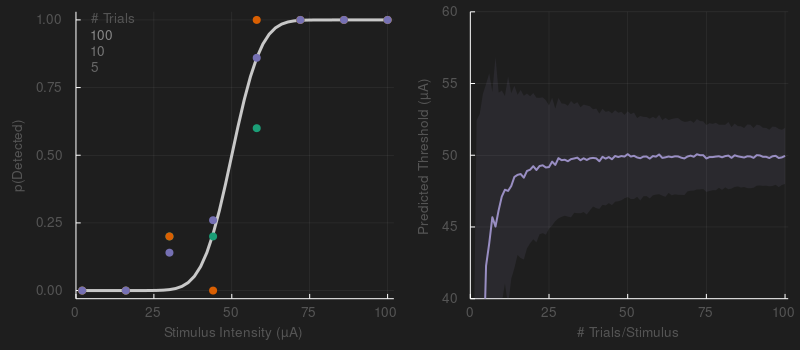

In [4]:
# Here we will choose which stimulus levels to test at
test_stims, test_stims_pDetected = GetConstantTargets(valid_stims, pDetected, Mode = "Unconstrained")
# Prepare plot
ConstantExamplePlot = plot(xlabel = "Stimulus Intensity (μA)", ylabel = "p(Detected)", xlim=(0, 102),
 size=(600,350))
    plot!(ConstantExamplePlot, valid_stims, pDetected, linecolor="rgb(200,200,200)", linewidth = 3)
    # Show for each number of trial
    yl = .85; y_dec = .06
    for (i,num_trials) in enumerate([5, 10, 100])
        _, pd = ConstantSimulation(test_stims, test_stims_pDetected, num_trials, NumPerms = 1, NumAFC = 2)
        scatter!(ConstantExamplePlot, test_stims, vec(pd),  marker=:circle, markersize=5, markeralpha=1,
        markercolor=ColorSchemes.Dark2_3[i], markerstrokecolor=ColorSchemes.Dark2_3[i])
        annotate!(ConstantExamplePlot, 5, yl, num_trials, annotationhalign=:left, annotationvalign=:top,
        annotationcolor=markerstrokecolor=ColorSchemes.Dark2_3[i])
        yl = yl + y_dec
    end
    annotate!(ConstantExamplePlot, 5, yl, "# Trials",
    annotationhalign=:left, annotationvalign=:top, annotationcolor="rgb(200,200,200)")

# Now we'll simulate the predictions as a function of # trials
max_repeats_per_intensity = 100 # A beyond reasonable number of trials
num_perms = 1000 # Increase this for smoother/cleaner results at the expense of time

# Simulate the method of constants
constant_num_trials_t_est = zeros(max_repeats_per_intensity, num_perms); fill!(constant_num_trials_t_est, NaN)
Threads.@threads for MaxReps = 1:max_repeats_per_intensity
    constant_num_trials_t_est[MaxReps,:], _ = ConstantSimulation(test_stims, test_stims_pDetected,
    MaxReps, NumPerms = num_perms, NumAFC = 2, BoundSig=false)
end
# Compute stats across permutations
t_mean_uconsts = vec(nanmean(constant_num_trials_t_est, dims = 2))
t_std_uconsts = vec(nanstd(constant_num_trials_t_est, dims = 2))
t_error_uconsts = vec(nanmean((constant_num_trials_t_est .- detection_threshold).^2, dims = 2))

x = collect(1:max_repeats_per_intensity)
ConstantsNumTrialsPlot = plot(xlabel = "# Trials/Stimulus", ylabel = "Predicted Threshold (μA)",
  xlim=(0, max_repeats_per_intensity+1), ylim=(40,60), size=(800,350))
plot!(ConstantsNumTrialsPlot, x, t_mean_uconsts, ribbon=t_std_uconsts, fillalpha=0.1, linewidth=2,
  linecolor=ColorSchemes.PuOr_3[3], fillcolor=ColorSchemes.PuOr_3[3])

plot(ConstantExamplePlot, ConstantsNumTrialsPlot, bottom_margin=5mm, left_margin=5mm)

Given that we used a 2AFC-task above, even with 100 trials we don't perfectly capture the distribution every time. You can re-run the cell to see how much variation there is, something that isn't present when NumAFC = 1, though that suffers from response bias. Simulating how our predictions change as a function of repeats we see that our average prediction is pretty close almost straight away, but the range of predictions is pretty substantial unless we have many repeats at each stimulus level.

##### Adaptive Methods: Transformed Staircase
The alternative approach is to 'adapt' to the responses and adjust the stimuli according to session history. One of the most popular approaches is the transformed staircase. In this approach you set a criteria and adjust the stimulus level once the criterion has been reached. The standard method is a 3U/1D staircase where the stimulus level decreases when the response is correct 3 times in a row and increases when the response is incorrect 1 time in a row. Each time the direction that the staircase is moving changes we count this after a reversion. The staircase will stop after a set number of reversions.

Importantly, each criterion will converge at a different location as will the task design. For example, 1-interval task with 1U/1D criterion will converge at 50%. However, a 2AFC task will 'converge' at 50% when no stimulus is present. Similarly, a 3U/1D criterion in 1-interval will target 75%, but in 2AFC will target ~56%.

In [12]:
criterion = [3,1]
num_afc = 2;
num_stair_perms = num_perms * 10
target_p = GetTransformedStaircaseTarget(num_afc, criterion)
target_amplitude = quantile(Normal(detection_threshold, sigma), target_p)
# Single staircase simulation
amplitude_history, detection_history, reversion_history, estimated_thresholds, stop_point = 
 TransformedStaircaseSimulation(valid_stims,  pDetected, Criterion = criterion,
  MaxReversions = 7, NumPerms = 1, NumAFC = num_afc) 
# Identify which trials were correct/incorrect
term_idx = findfirst(isnan.(amplitude_history))[1]
correct_idx = findall(vec(detection_history[1:term_idx]) .== 1)
incorrect_idx = findall(vec(detection_history[1:term_idx]) .== 0)

# Now let's look at how accuracy changes as a function of # reversions
max_num_reversions = 100 # Similarly excessive
# Repeat for the staircase and number of reversions
staircase_num_revs_t_est = zeros(max_num_reversions, num_stair_perms); fill!(staircase_num_revs_t_est, NaN)
staircase_num_revs_t_stop = zeros(max_num_reversions, num_stair_perms); fill!(staircase_num_revs_t_stop, NaN)
Threads.@threads for MaxReversions = 3:max_num_reversions
  _, _, _, staircase_num_revs_t_est[MaxReversions,:], staircase_num_revs_t_stop[MaxReversions,:] =
   TransformedStaircaseSimulation(valid_stims, pDetected, MaxReversions = MaxReversions, NumPerms = num_stair_perms, NumAFC = 2,
   SkipFirstNReversions = 2, InitAmp = Int(round(target_amplitude)), InitStepSize = 10)
end
# Compute stats across permutations
t_mean_tstairs = vec(nanmean(staircase_num_revs_t_est, dims = 2))
t_std_tstairs = vec(nanstd(staircase_num_revs_t_est, dims = 2))
t_error_tstairs = vec(nanmean((staircase_num_revs_t_est .- target_amplitude).^2, dims = 2))

# Make the plot
StaircaseExamplePlot = plot(xlabel = "Trial #", ylabel = "Stimulus Amplitude (μA)",
  xlim=(0, term_idx+1), ylim=(0,100))
  # Show target/convergence point
  plot!(StaircaseExamplePlot, [0,term_idx+1], [target_amplitude, target_amplitude],
   color="rgb(200,200,200)", linestyle=:dot)
  annotate!(StaircaseExamplePlot, term_idx+1, target_amplitude-1, "Target",
  annotationhalign=:right, annotationvalign=:top, annotationcolor="rgb(200,200,200)")
  # Show trial history
  plot!(StaircaseExamplePlot, 1:term_idx, amplitude_history[1:term_idx],
   color="rgb(200,200,200)", linestyle=:dash)
  scatter!(StaircaseExamplePlot, correct_idx, amplitude_history[correct_idx],
   markercolor=ColorSchemes.Dark2_3[1],
  markerstrokecolor=ColorSchemes.Dark2_3[1])
  scatter!(StaircaseExamplePlot, incorrect_idx, amplitude_history[incorrect_idx],
   markercolor=ColorSchemes.Dark2_4[4],
  markerstrokecolor=ColorSchemes.Dark2_4[4])
  annotate!(StaircaseExamplePlot, 1, 100, "Correct",
  annotationhalign=:left, annotationvalign=:top, annotationcolor=ColorSchemes.Dark2_3[1])
  annotate!(StaircaseExamplePlot, 1, 95, "Incorrect",
  annotationhalign=:left, annotationvalign=:top, annotationcolor=ColorSchemes.Dark2_4[4])
  annotate!(StaircaseExamplePlot, term_idx+0.5, estimated_thresholds[1], "⋆",
  annotationhalign=:right, annotationvalign=:center, annotationcolor=:gold, annotationfontsize=15)

StaircaseNumReversionsPlot = plot(xlabel = "# Reversions", ylabel = "Predicted Threshold (μA)",
  xlim=(0, max_num_reversions+1), ylim=(40,60), size=(800,350))
  plot!(StaircaseNumReversionsPlot, collect(1:max_num_reversions), t_mean_tstairs, ribbon=t_std_tstairs,
   fillalpha=0.1, linewidth=2, linecolor=ColorSchemes.PuOr_3[1], fillcolor=ColorSchemes.PuOr_3[1])

  plot(StaircaseExamplePlot, StaircaseNumReversionsPlot, bottom_margin=5mm, left_margin=5mm)


TaskFailedException: TaskFailedException

    nested task error: TypeError: in keyword argument InitAmp, expected Int64, got a value of type Float64
    Stacktrace:
     [1] macro expansion
       @ c:\GitHub\BCIDetectionThresholdSimulations\DetectionThresholdNotebook.ipynb:21 [inlined]
     [2] (::var"#331#threadsfor_fun#23"{UnitRange{Int64}})(onethread::Bool)
       @ Main .\threadingconstructs.jl:85
     [3] (::var"#331#threadsfor_fun#23"{UnitRange{Int64}})()
       @ Main .\threadingconstructs.jl:52

##### Comparing Time & Accuracy
The above code blocks show that either method can be used to measure/estimate the detection threshold though and that performance increases as a function of trials/reversions. The most obvious metric to use in comparisons (for a time consciouss experimenter) is how the accuracy of the estimate changes with time. This means that we need to convert # Reversions and # Trials/Stimulus to # Trials. In the constants case this is #Trials/Stimulus * NumStimuli, but for the stairscase each one has a different number of trials so we need to evaluate each one seperately.

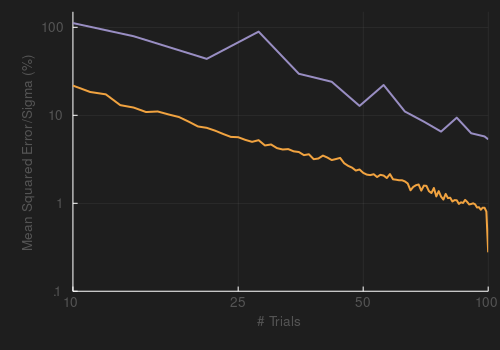

In [10]:
# Sort the staircase values
max_rt = 100
# Convert to vec for Histogram function
t_stop_vec = vec(staircase_num_revs_t_stop); 
t_est_vec = vec(staircase_num_revs_t_est)
h = fit(Histogram, t_stop_vec, 1:max_rt) 
# This gives up the bin index (== t_stop) that we can use on t_est
indmap = StatsBase.binindex.(Ref(h), t_stop_vec)
t_mean_staircase_sorted = zeros(max_rt)
t_std_staircase_sorted = zeros(max_rt)
t_error_staircase_sorted = zeros(max_rt)
for tr = 1:max_rt
    tr_idx = findall(indmap .== tr)
    if length(tr_idx) > 0
        t_mean_staircase_sorted[tr] = nanmean(t_est_vec[tr_idx])
        t_std_staircase_sorted[tr] = nanstd(t_est_vec[tr_idx])
        t_error_staircase_sorted[tr] = nanmean((t_est_vec[tr_idx].- target_amplitude).^2) # Need to subtract target amplitude instead
    end
end

ErrorComparisonPlot = plot(xlabel = "# Trials", ylabel = "Mean Squared Error/Sigma (%)", xlim=(10, 100),
 size=(500,350), bottom_margin=5mm, left_margin=5mm, xscale=:log10, yscale=:log10, ylim=(1e-1, 150),
 xticks=([10, 25, 50, 100], ["10", "25", "50", "100"]), yticks=([.1, 1, 10, 100], [".1", "1", "10", "100"]))
plot!(ErrorComparisonPlot, collect(1:max_repeats_per_intensity).*length(test_stims), t_error_uconsts./sigma,
 linecolor=ColorSchemes.PuOr_3[3], linewidth=2)
plot!(ErrorComparisonPlot, 1:max_rt, t_error_staircase_sorted./sigma, linecolor=ColorSchemes.PuOr_3[1], linewidth=2)


Perhaps as expected, we see that the error decreases as a function of # trials for both and that the error is substantially lower for the staircase method than the naive constants for the same number of trials. Indeed, for the error to be within 10% of the sigma value you need 25 trials for the staircase but ~100 for constants.

##### Opimizing the Method of Constants
One reason that the method of constants performs relatively poorly is because it's the worst possible version of it. For the example we are using with 12 stimulus levels, the first and last 3 intensities all contain redundant information as the p(Detected) is the same for those values due to the asymtotic nature of an ogival (CDF like) function. In a naive setting, this is unaviodable as we have no prior expectations on what the detection threshold should be. In BCI, however, we often repeat the threshold measurement on each electrode every few months and sometimes more often. In these cases then we will have a prior assumption about what stimulus levels to test at and that would allow us to constrain the stimulus levels used in the method of constants to a more appropriate range. First, however, this means we must determine what the optimal range and sampling density is for a given psychometric curve. Another, constraint/assumption we can add is to append values to the sigmoid fit to reduce noise. For example, we can add a point at the lower and upper bound with a p(Detected) of 0 and 100 respectively.

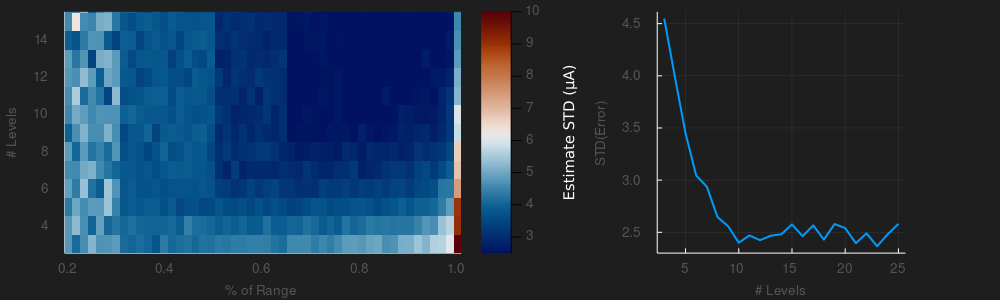

In [7]:
num_repeats = 10 # The exact number doesn't matter as it's all relative
num_levels = 3:25 # How many stimulus levels to use (centered around DT)
widths = range(0.2,1,50) # What proportion of the psychometric curve should we sample 
t_mean_optim = zeros(length(num_levels), length(widths)); fill!(t_mean_optim, NaN)
t_std_optim = zeros(length(num_levels), length(widths)); fill!(t_std_optim, NaN)

# Here we will get new stimulus levels for each number of intensities and width of the curve
for (lidx,l) in enumerate(num_levels)
    Threads.@threads for (widx,w) in collect(enumerate(widths)) # 
        test_stims, test_stims_pDetected = GetConstantTargets(valid_stims, pDetected,
        Mode = "Constrained", NumStimLevels = l, PsychRange = [0.5-w/2, 0.5+w/2])
        t_pred, _ = ConstantSimulation(test_stims, test_stims_pDetected, num_repeats, NumPerms = num_perms,
         BoundSig = true)
        t_pred = convert(Vector{Float64}, t_pred)
        t_mean_optim[lidx,widx] = nanmean(t_pred)
        t_std_optim[lidx,widx] = nanstd(t_pred)
    end
end

optim_heatmap = plot(xlabel = "% of Range", ylabel = "# Levels")
    heatmap!(optim_heatmap, collect(widths), collect(num_levels), t_std_optim, c=:vik, colorbar=true,
    colorbar_title="Estimate STD (μA)", clim=(2.5, 10), ylim=(2.5, 15.5))

# The heatmap shows that at 0.68 width (1 standard deviation) then improvements taper
# Though performance improves with # levels we can't indefinitely add that as it will make
# trials take longer so lets see where it asymptotes
(_,idx) = findmin(abs.(collect(widths) .- 0.68))
num_levels_optim_plot = plot(xlabel = "# Levels", ylabel = "STD(Error)")
    plot!(num_levels, t_std_optim[:,idx])

l = @layout [a{0.6w} b{0.3w}]
plot(optim_heatmap, num_levels_optim_plot,
 bottom_margin=5mm, left_margin=5mm, layout=l, size=(1000, 300))

##### Benchmarking Optimized Constants
Now that we know to use 1 standard deviation of the range and 8-10 levels, we can test performance at that level and then make the comparison.

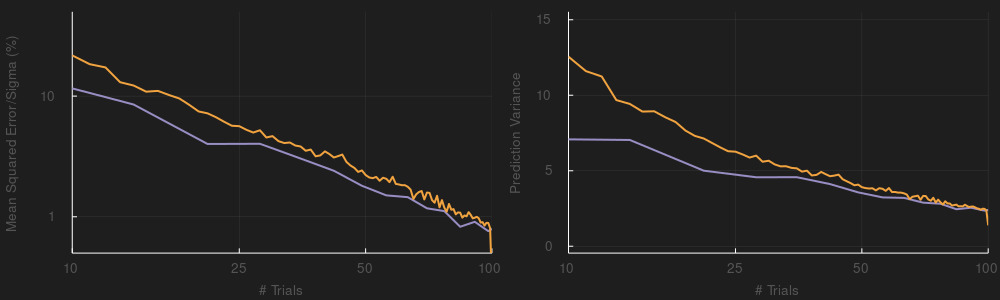

In [11]:
num_perms = 1000 # Increase this for smoother/cleaner results at the expense of time
# Define new values
test_stims, test_stims_pDetected = GetConstantTargets(valid_stims, pDetected, Mode = "Constrained", PsychRange = [0.175, 0.825])
# Repeat the analysis
# Simulate the method of constants
constant_num_trials_t_est_optim = zeros(max_repeats_per_intensity, num_perms); fill!(constant_num_trials_t_est_optim, NaN)
Threads.@threads for MaxReps = 1:max_repeats_per_intensity
    constant_num_trials_t_est_optim[MaxReps,:], _ = ConstantSimulation(test_stims, test_stims_pDetected,
    MaxReps, NumPerms = num_perms, NumAFC = 2, BoundSig=true)
end
# Compute stats across permutations
t_mean_uconsts_optim = vec(nanmean(constant_num_trials_t_est_optim, dims = 2))
t_std_uconsts_optim = vec(nanstd(constant_num_trials_t_est_optim, dims = 2))
t_error_uconsts_optim = vec(nanmean((constant_num_trials_t_est_optim .- detection_threshold).^2, dims = 2))

ErrorComparisonPlot = plot(xlabel = "# Trials", ylabel = "Mean Squared Error/Sigma (%)", xlim=(10, 100),
 size=(500,350), xscale=:log10, yscale=:log10, ylim=(.5, 50),
 xticks=([10, 25, 50, 100], ["10", "25", "50", "100"]), yticks=([.1, 1, 10, 100], [".1", "1", "10", "100"]))
plot!(ErrorComparisonPlot, collect(1:max_repeats_per_intensity).*length(test_stims), t_error_uconsts_optim./sigma,
 linecolor=ColorSchemes.PuOr_3[3], linewidth=2)
plot!(ErrorComparisonPlot, 1:max_rt, t_error_staircase_sorted./sigma, linecolor=ColorSchemes.PuOr_3[1], linewidth=2)

STDComparisonPlot = plot(xlabel = "# Trials", ylabel = "Prediction Variance", xlim=(10, 100),
 size=(500,350), xscale=:log10, xticks=([10, 25, 50, 100], ["10", "25", "50","100"]))
plot!(STDComparisonPlot, collect(1:max_repeats_per_intensity).*length(test_stims), t_std_uconsts_optim,
 linecolor=ColorSchemes.PuOr_3[3], linewidth=2)
plot!(STDComparisonPlot, 1:max_rt, t_std_staircase_sorted, linecolor=ColorSchemes.PuOr_3[1], linewidth=2)

plot(ErrorComparisonPlot, STDComparisonPlot, bottom_margin=5mm, left_margin=5mm, size=(1000, 300))